# High-Fidelity Visualization of the Expert Action Distribution

**Objective:** To load ALL expert actions from the pre-featurized dataset
into memory and create a high-resolution 2D histogram/KDE plot. This provides
the most accurate possible visualization of the true data distribution,
independent of the specific binning used for the loss function.

In [1]:
# ## 1. Setup and Configuration

# +
import os
import sys
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config

config = load_config(config_path='../configs/main_config.yaml')
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

Configuration loaded successfully.


In [15]:
# ## 2. Load All Actions in Parallel
# 
# This is a one-time, memory-intensive operation. We will load the 'actions'
# tensor from every training file and concatenate them into a single array.
import traceback
# +
# --- Worker function for parallel loading ---
def load_actions_worker(pt_path: str) -> np.ndarray:
    """Loads a .pt file and returns just the actions as a NumPy array."""
    try:
        data = torch.load(pt_path, weights_only=False)
        
        actions = []
        # Iterate over the list 
        for timestep in data:
            actions.append(timestep['action'])
        return np.array(actions)
    except Exception:
        # Return an empty array if a file is corrupted
        traceback.print_exc()
        raise RuntimeError(f"Failed to load '{pt_path}'")

# --- Main loading logic ---
train_data_dir = os.path.join(config['data']['featurized_dir_v2'], 'training')
data_files = glob(os.path.join(train_data_dir, '*.pt'))

if not data_files:
    raise FileNotFoundError(f"No featurized .pt files found in '{train_data_dir}'.")

print(f"Loading actions from {len(data_files)} scenario files in parallel...")

with Pool(processes=cpu_count()) as pool:
    results = list(tqdm(pool.imap(load_actions_worker, data_files), total=len(data_files)))

# Concatenate all the action arrays into one giant array
print("\nConcatenating all actions...")
all_actions = np.concatenate(results, axis=0)

print(f"✅ Loaded a total of {len(all_actions)} actions.")
# Create a DataFrame for easier plotting with Seaborn
actions_df = pd.DataFrame(all_actions, columns=['acceleration', 'yaw_rate'])

Loading actions from 97631 scenario files in parallel...


100%|██████████| 97631/97631 [03:35<00:00, 454.02it/s]


Concatenating all actions...
✅ Loaded a total of 8786790 actions.


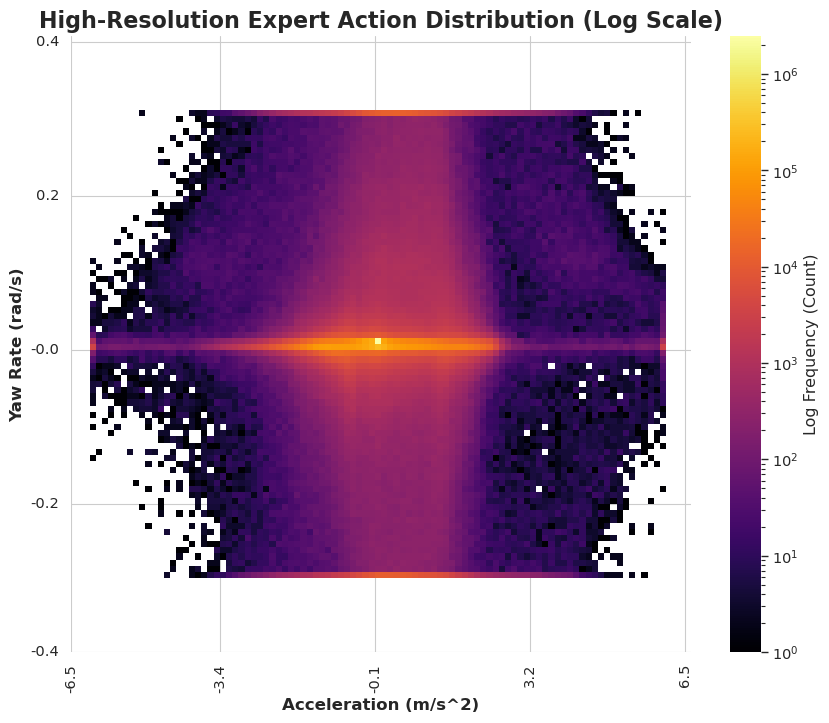

In [46]:
# In notebooks/plot_true_action_distribution.ipynb, Cell #3

# --- 1. Calculate the 2D histogram data using NumPy ---
# This gives us the counts and the bin edge definitions
counts, xedges, yedges = np.histogram2d(
    actions_df['acceleration'], 
    actions_df['yaw_rate'], 
    bins=(100, 100),
    # Explicitly set the range to match your config for a clean plot
    range=[
        [-6.5, 6.6],
        [-0.4, 0.4]
    ]
)

# --- 2. Create the LogNorm object ---
log_norm = mcolors.LogNorm(vmin=1, vmax=np.max(counts))

# --- 3. Create the Plot using sns.heatmap ---
plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    counts.T, # Transpose so acceleration is X and yaw rate is Y
    cmap="inferno",
    norm=log_norm,
    cbar=True,
    cbar_kws={'label': 'Log Frequency (Count)'}
)
ax.invert_yaxis() # Put 0,0 at the center

# --- 4. THIS IS THE CRITICAL FIX: Set Custom Axis Ticks and Labels ---
# We will select a few (e.g., 5) locations on the 0-100 index scale to place our ticks.
xtick_indices = np.linspace(0, 99, 5).astype(int)
ytick_indices = np.linspace(0, 99, 5).astype(int)

# Set the tick locations on the plot to these indices
ax.set_xticks(xtick_indices)
ax.set_yticks(ytick_indices)

# Now, we create the LABELS for these ticks using the REAL values from the bin edges.
# We get the corresponding acceleration/yaw_rate value at each tick index.
xtick_labels = [f"{xedges[i]:.1f}" for i in xtick_indices]
ytick_labels = [f"{yedges[i]:.1f}" for i in ytick_indices]

# Set the tick labels on the plot
ax.set_xticklabels(xtick_labels)
ax.set_yticklabels(ytick_labels)
# --- END OF FIX ---


plt.xlabel("Acceleration (m/s^2)", fontsize=12, weight='bold')
plt.ylabel("Yaw Rate (rad/s)", fontsize=12, weight='bold')
plt.title("High-Resolution Expert Action Distribution (Log Scale)", fontsize=16, weight='bold')

# plt.xlim(-6, 7)

# Save the figure
plt.savefig('outputs/figure_action_distribution_high_res.png', dpi=300, bbox_inches='tight')
plt.savefig('outputs/figure_action_distribution_high_res.pdf', bbox_inches='tight')

plt.show()

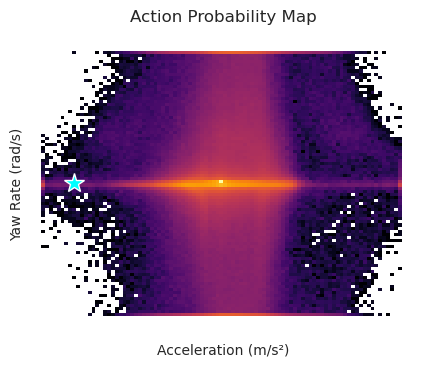

In [56]:
# ## 4. Generate Compact Version for Conceptual Figure
# 
# This cell creates a smaller, simplified version of the heatmap, perfect for
# embedding in other figures or for presentations.

# +
# --- Data calculation is the same as before ---
counts, xedges, yedges = np.histogram2d(
    actions_df['acceleration'], 
    actions_df['yaw_rate'], 
    bins=(100, 100),
    range=[
        [-6.5, 6.6],
        [-0.35, 0.35]
    ]
)
log_norm = mcolors.LogNorm(vmin=1, vmax=np.max(counts))

# --- Create the Plot with a NEW, SMALLER figsize ---
# Change figsize from (10, 8) to (5, 4)
plt.figure(figsize=(5, 4))

ax = sns.heatmap(
    counts.T,
    cmap="inferno",
    norm=log_norm,
    cbar=False # --- Turn off the color bar for a cleaner, minimalist look ---
)
ax.invert_yaxis()

# --- Simplify the plot for a cleaner look ---
# For an embedded figure, we often don't need detailed axes.
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Acceleration (m/s²)', fontsize=10)
ax.set_ylabel('Yaw Rate (rad/s)', fontsize=10)
ax.set_title("Action Probability Map", fontsize=12)


# --- Example of adding the "rare action" dot for the designer ---
# This part is optional but shows how to create the asset for the conceptual figure.
rare_accel = -5.0
rare_steer = 0.0

# Convert the real action value to a bin index
accel_idx = np.interp(rare_accel, xedges, range(len(xedges)))
steer_idx = np.interp(rare_steer, yedges, range(len(yedges)))

# Plot a glowing star at that position
ax.plot(accel_idx, steer_idx, '*', color='cyan', markersize=15, markeredgecolor='white', zorder=10)
# --- End of optional part ---


# Save the compact figure
plt.savefig('outputs/figure_action_distribution_compact.png', dpi=300, bbox_inches='tight')
plt.savefig('outputs/figure_action_distribution_compact.pdf', bbox_inches='tight')

plt.show()